In [371]:
import sys
sys.path.append("../")
from tfMFs.tfCMF import tfCMF
# from dataset import create_synthetic_data
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [297]:
from scipy import stats

# 文長の生成

### Toxic Comment

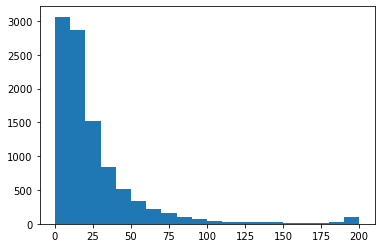

In [315]:
df = pd.read_csv("/home/ryo_matsui/notebook/mydata/ToxicComment/jigsaw-toxic-comment-train.csv")
vectorizer = CountVectorizer(min_df=0, max_df=np.inf, stop_words="english", binary=True)
X_toxic = vectorizer.fit_transform(df.head(10000).comment_text)
y_toxic = df.head(10000).toxic.values
plt.hist(np.clip(X_toxic.sum(axis=1).A.ravel(), 0,200),bins=20)
plt.show()

In [300]:
X.shape

(10000, 36074)

### Synthetic

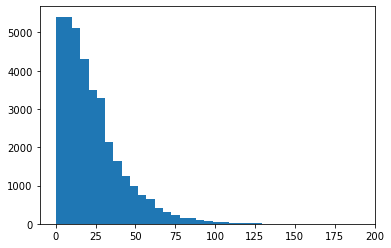

In [292]:
lam = stats.gamma.rvs(1.5,scale=15, size=36000)
length = stats.poisson.rvs(lam)
plt.hist(length,bins=50)
plt.xlim(-10,200)
plt.show()

# 単語 / トピックの生成

In [377]:
def generate_synthetic_dataset(n_docs_pos:int = 1000, n_docs_neg:int = 9000, n_words:int = 36000, 
                               K:int = 10, shape:float = 1.5, scale:float = 15, alpha_max=1, beta_max=1):
    
    alpha_pos = np.random.rand(K) * alpha_max
    alpha_neg = np.random.rand(K) * alpha_max
    beta = np.random.rand(n_words) * beta_max

    theta_pos = stats.dirichlet.rvs(alpha_pos, size=n_docs_pos) # n_docs_pos × K
    theta_neg = stats.dirichlet.rvs(alpha_neg, size=n_docs_neg) # n_docs_neg × K

    lam_pos = stats.gamma.rvs(shape, scale=scale, size=n_docs_pos)
    lam_neg = stats.gamma.rvs(shape, scale=scale, size=n_docs_neg)

    length_pos = stats.poisson.rvs(lam_pos) # n_docs_pos
    length_neg = stats.poisson.rvs(lam_neg) # n_docs_neg

    z_pos = np.array([stats.multinomial.rvs(n=length_pos[i],p=theta_pos[i]) for i in range(n_docs_pos)]) # n_docs_pos × K
    z_neg = np.array([stats.multinomial.rvs(n=length_neg[i],p=theta_neg[i]) for i in range(n_docs_neg)]) # n_docs_neg × K
    z = np.r_[z_pos, z_neg]

    phi = stats.dirichlet.rvs(beta, size=K) # K × n_words
    X = np.array([
        np.array([stats.multinomial.rvs(n=z[i,k], p=phi[k]).tolist() for k in range(K)]).sum(axis=0)
        for i in tqdm(range(n_docs_pos + n_docs_neg))
    ])
    y = np.r_[np.ones(n_docs_pos), np.zeros(n_docs_neg)]
    
    return X, y

### utility

In [351]:
def calc_sparsity(X):
    if X.__class__ == np.ndarray:
        sparsity = csr_matrix(X).nnz / X.shape[0] / X.shape[1]
    else:
        sparsity = X.nnz / X.shape[0] / X.shape[1]
    return sparsity

In [327]:
def clip_by_document_frequency(X, min_df, max_df):
    
    if X.__class__ == np.ndarray:
        df = X.sum(axis=0)
    else:
        df = X.sum(axis=0).A[0]
        
    lower_bound = df >= min_df
    upper_bound = df <= max_df
    
    X_cliped = X[:, lower_bound & upper_bound]
    return X_cliped

## clip 前のスパース性 / 頻度分布

### - toxic

In [353]:
calc_sparsity(X_toxic)

0.0007108416033708489

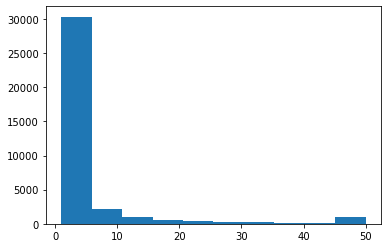

In [350]:
plt.hist(np.clip(X_toxic.sum(axis=0).A[0], 0,50),bins=10)
plt.show()

### - synthetic

In [378]:
X, y = generate_synthetic_dataset(
    n_docs_pos = 1000, 
    n_docs_neg= 9000, 
    n_words = 36000, 
    K = 10, 
    shape = 1.5, 
    scale = 15, 
    alpha_max=2, 
    beta_max=1
)

100%|██████████| 10000/10000 [08:07<00:00, 20.53it/s]


In [379]:
calc_sparsity(X)

0.0005452194444444445

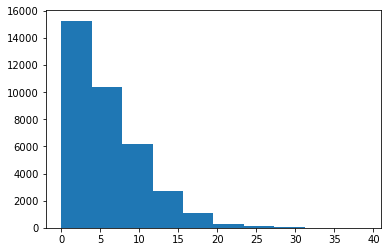

In [382]:
plt.hist(X.sum(axis=0),bins=10)
plt.show()

## clip後のスパース性 / 頻度分布

### - toxic

In [362]:
X_toxic_clip = clip_by_document_frequency(X_toxic, 3, 50)

In [363]:
X_toxic_clip.shape

(10000, 9045)

In [364]:
calc_sparsity(X_toxic_clip)

0.0010234162520729685

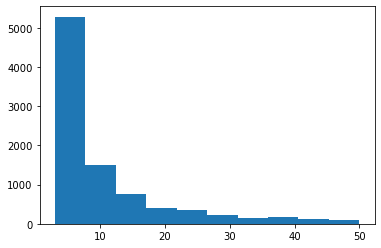

In [365]:
plt.hist(np.clip(X_toxic_clip.sum(axis=0).A[0], 0,50),bins=10)
plt.show()

### - synthetic

In [366]:
X_clip = clip_by_document_frequency(X, 8, 50)

In [367]:
X_clip.shape

(10000, 10242)

In [368]:
calc_sparsity(X_clip)

0.0011488088264010935

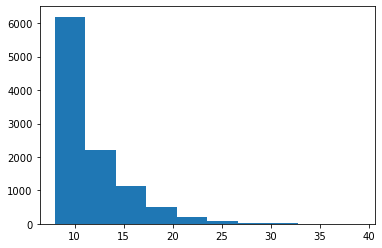

In [381]:
plt.hist(np.clip(X_clip.sum(axis=0), 0,50),bins=10)
plt.show()

# K = 10

In [ ]:
X, y = generate_synthetic_dataset(
    n_docs_pos = 1000, 
    n_docs_neg= 9000, 
    n_words = 36000, 
    K = 10, 
    shape = 1.5, 
    scale = 15, 
    alpha_max=2, 
    beta_max=1
)

In [392]:
X_clip = clip_by_document_frequency(X, 8, 50)

In [393]:
calc_sparsity(X_clip)

0.0011649132947976878

## d = 5

In [405]:
cmf = tfCMF(alpha=0.7, d_hidden=5, lamda=1)
U, V, Z, train_loss_SGD, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="SGD")

100%|██████████| 600/600 [20:01<00:00,  2.00s/it]


In [406]:
cmf = tfCMF(alpha=0.7, d_hidden=5, lamda=1)
U, V, Z, train_loss_Adam, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="Adam")

100%|██████████| 600/600 [19:57<00:00,  2.00s/it]


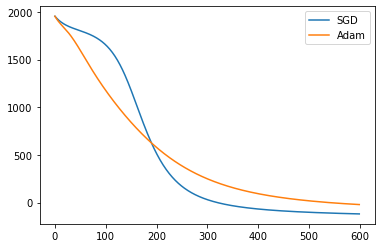

In [407]:
plt.plot(np.arange(0,600),train_loss_SGD, label="SGD")
plt.plot(np.arange(0,600),train_loss_Adam, label="Adam")
plt.legend()
plt.show()

## d = 10

In [396]:
cmf = tfCMF(alpha=0.7, d_hidden=10, lamda=1)
U, V, Z, train_loss_SGD, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="SGD")

100%|██████████| 600/600 [20:09<00:00,  2.02s/it]


In [398]:
cmf = tfCMF(alpha=0.7, d_hidden=10, lamda=1)
U, V, Z, train_loss_Adam, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="Adam")

100%|██████████| 600/600 [20:03<00:00,  2.01s/it]


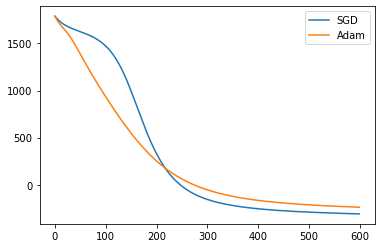

In [399]:
plt.plot(np.arange(0,600),train_loss_SGD, label="SGD")
plt.plot(np.arange(0,600),train_loss_Adam, label="Adam")
plt.legend()
plt.show()

## d = 20

In [ ]:
cmf = tfCMF(alpha=0.7, d_hidden=20, lamda=1)
U, V, Z, train_loss_SGD, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="SGD")

 70%|██████▉   | 417/600 [14:13<06:09,  2.02s/it]

In [ ]:
cmf = tfCMF(alpha=0.7, d_hidden=20, lamda=1)
U, V, Z, train_loss_Adam, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="Adam")

In [ ]:
plt.plot(np.arange(0,600),train_loss_SGD, label="SGD")
plt.plot(np.arange(0,600),train_loss_Adam, label="Adam")
plt.legend()
plt.show()

## d = 100

In [400]:
cmf = tfCMF(alpha=0.7, d_hidden=100, lamda=1)
U, V, Z, train_loss_SGD, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="SGD")

100%|██████████| 600/600 [22:17<00:00,  2.23s/it]


In [401]:
cmf = tfCMF(alpha=0.7, d_hidden=100, lamda=1)
U, V, Z, train_loss_Adam, _ = cmf.train(X_clip, X_clip, y[:,np.newaxis], optim_steps=600, early_stopping=5, lr=0.001, optimizer="Adam")

 64%|██████▎   | 381/600 [14:15<08:11,  2.25s/it]


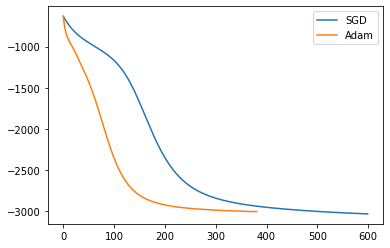

In [404]:
plt.plot(np.arange(0,600),train_loss_SGD, label="SGD")
plt.plot(np.arange(0,382),train_loss_Adam, label="Adam")
plt.legend()
plt.show()